Изучение контрольной и тестовой выборки 2-мя методами: с помощью бутстрапа и с помощью критерия Манна-Уитни.
Выяснение разницы результатов и анализ, почему эта разница существует.  

Дано:  
таблица, где числовая переменная – непрерывная. Половина таблицы - контрольная группа, половина - тестовая. Столбцы:  
    
    value – значения метрики
    experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
 
Задача – сравнить группы двумя способами: бутстрапом и u-тестом


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv',sep=';')

In [3]:
df.value = df.value.str.replace(',','.').apply(lambda x: float(x))

In [4]:
# формируем 2 отдельные выборки
control = df.query("experimentVariant == 'Control'").value 
test = df.query("experimentVariant == 'Treatment'").value

In [5]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
       
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

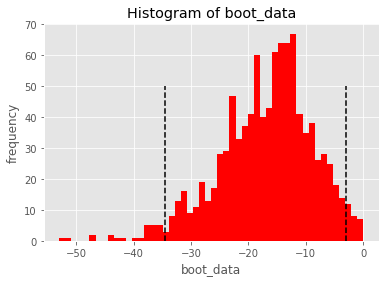

In [6]:
# проверям бутстрапом гипотезу о равенстве средних 

booted_data_mean = get_bootstrap(control, test)

In [7]:
booted_data_mean['p_value'] 

0.03781084443331215

нулевую гипотезу о равенстве средних в выборках можно отвергнуть (при пороговом < 0.05)

In [8]:
# применяем критерий Манна-Уитни
mannwhitneyu(control, test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

p-value гораздо выше, чем p-value при бутстрапе средних
критерий показывает, что распределениия Контроля и Теста значимо не различаются

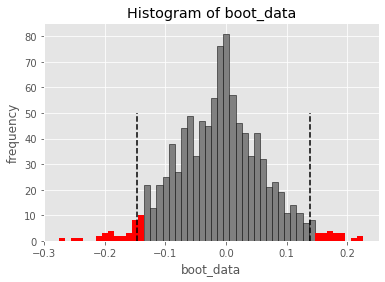

In [9]:
# проверям бутстрапом гипотезу о равенстве медиан 

booted_data_median = get_bootstrap(control, test,statistic=np.median)

In [10]:
booted_data_median['p_value']

0.8814783808903982

p_value очень высокое. Гораздо выше, чем p-value по критерию Манна-Уитни
нулевая гипотеза о равенстве медиан в выборках подтверждается

#### АНАЛИЗ И ВЫВОДЫ 
Итак мы имеем 2 распределения, которые однородны по критерию Манна-Уитни,
по бутстрапу имеющие статистически значимые равные медианы, но значимо разные средние. Почему так выходит?

In [11]:
# посмотрим на показатели обеих групп
print(control.describe())
print(test.describe())

count    500.000000
mean      10.026867
std        0.979377
min        6.436541
25%        9.411024
50%       10.018465
75%       10.664879
max       13.130346
Name: value, dtype: float64
count     500.000000
mean       27.321499
std       186.557011
min         6.436541
25%         9.421968
50%        10.025847
75%        10.675721
max      3000.000000
Name: value, dtype: float64


все квантили в обеих выборках примерно равны. Только максимум Теста гораздо выше

In [12]:
# посмотрим, какие значения в Тесте выше максимума Контроля
df[df.value > max(control)]

,Unnamed: 0,value,experimentVariant
995,996,1000.0,Treatment
996,997,1200.0,Treatment
997,998,1500.0,Treatment
998,999,2000.0,Treatment
999,1000,3000.0,Treatment


В Тесте мы среди 500 значений имеем 5 очень сильных выбросов.
Критерий Манна-Уитни не сильно чувствителен к наличию выбросов, 
не давая нам значимый p-value при сравнении распеределений.

Бутстрап по разнице медиан вообще практически не чувствителен к выбросам,
так как сравнивается не сумма рангов выборок, как в Манна-Уитни, а только один ранг - медиана.
Поэтому p-value еще выше.

Бутстрап по разнице средних напротив сразу показывает статистическую разницу средних, которая появляется из-за 
5 гигантских выбросов в Тесте

Данный пример показывает хорошие возможности применения бутстрапа.
Мы можем сравнивать отдельные характеристики распределений, что недоступно при применении классических критериев,
оценивающих равенство распределений в общем